## Part II: Visualise saliency maps
- import already trained baseline model and check its accuracy
- simple visualisation of backproped gradients
- take steps into the direction of the gradient, starting  from a test image. This shows us how to modify an image to make it look more like the class it is taken from, according to the network.


### Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import time

import tensorflow as tf

# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# we will use Sonnet on top of TF 
!pip install -q dm-sonnet
import sonnet as snt

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

Found GPU at: /device:GPU:0


In [0]:
# Reset graph
tf.reset_default_graph()


### Copy the pretrained weights of baseline model on the virtual machine
- you need to load all three files in the *baseline* folder
- this loads a model with the same architecture that you defined earlier, but fully trained.

In [0]:
from google.colab import files

uploaded = files.upload()

print(uploaded)

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving baseline.ckpt.data-00000-of-00001 to baseline.ckpt.data-00000-of-00001


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Download dataset to be used for training and testing
- Cifar-10 equivalent of MNIST for natural RGB images
- 60000 32x32 colour images in 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- train: 50000; test: 10000

In [0]:
cifar10 = tf.keras.datasets.cifar10
# (down)load dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

### Prepare the data for training and testing
- for training, we use stochastic optimizers (e.g. SGD, Adam), so we need to sample at random mini-batches from the training dataset
- for testing, we iterate sequentially through the test set

In [0]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 128 #@param
BATCH_SIZE_TEST = 5 #@param

# create Dataset objects using the data previously downloaded
dataset_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# we shuffle the data and sample repeatedly batches for training
batched_dataset_train = dataset_train.shuffle(100000).repeat().batch(BATCH_SIZE_TRAIN)
# create iterator to retrieve batches
iterator_train = batched_dataset_train.make_one_shot_iterator()
# get a training batch of images and labels
(batch_train_images, batch_train_labels) = iterator_train.get_next()

In [0]:
# we do the same for test dataset
dataset_test = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
batched_dataset_test = dataset_test.repeat().batch(BATCH_SIZE_TEST)
iterator_test = batched_dataset_test.make_one_shot_iterator() 
(batch_test_images, batch_test_labels) = iterator_test.get_next()

### Define model on which we will run visualisation

In [0]:
class Baseline(snt.AbstractModule):
  
  def __init__(self, num_classes, name="baseline"):
    super(Baseline, self).__init__(name=name)
    self._num_classes = num_classes
    self._output_channels = [
        64, 64, 128, 128, 128, 256, 256, 256, 512, 512, 512
        ]
    self._num_layers = len(self._output_channels)

    self._kernel_shapes = [[3, 3]] * self._num_layers  # All kernels are 3x3.
    self._strides = [1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1]
    self._paddings = [snt.SAME] * self._num_layers
   
  def _build(self, inputs, is_training=None, test_local_stats=False):
    net = inputs
    # instantiate all the convolutional layers 
    layers = [snt.Conv2D(name="conv_2d_{}".format(i),
                         output_channels=self._output_channels[i],
                         kernel_shape=self._kernel_shapes[i],
                         stride=self._strides[i],
                         padding=self._paddings[i],
                         use_bias=True) for i in xrange(self._num_layers)]
    # connect them to the graph, adding batch norm and non-linearity
    for i, layer in enumerate(layers):
      net = layer(net)
      bn = snt.BatchNorm(name="batch_norm_{}".format(i))
      net = bn(net, is_training=is_training, test_local_stats=test_local_stats)
      net = tf.nn.relu(net)

    net = tf.reduce_mean(net, reduction_indices=[1, 2], keepdims=False,
                         name="avg_pool")

    logits = snt.Linear(self._num_classes)(net)

    return logits

In [0]:
num_classes = 10

In [0]:
# Instantiate the model and create saver to restore pre-trained model
with tf.variable_scope("baseline"):
  model = Baseline(num_classes)
  
batch_test_images = tf.image.convert_image_dtype(batch_test_images, 
                                                 dtype=tf.float32)
batch_test_images = batch_test_images * 2.0 - 1.0
test_predictions = model(batch_test_images, is_training=False)

var_list = snt.get_variables_in_scope("baseline", 
                                      collection=tf.GraphKeys.GLOBAL_VARIABLES)  

var_map = {}
for i in range(0, len(var_list)):
  name = var_list[i].name[len("baseline/"):-2]
  var_map[name] = var_list[i]

saver = tf.train.Saver(var_map, reshape=True)

In [0]:
# for evaluation, we look at top_k_accuracy since it's easier to interpret; normally k=1 or k=5
def top_k_accuracy(k, labels, logits):
  in_top_k = tf.nn.in_top_k(predictions=tf.squeeze(logits), 
                            targets=tf.squeeze(tf.cast(labels, tf.int32)), k=k)
  return tf.reduce_mean(tf.cast(in_top_k, tf.float32))

In [0]:
test_acc = top_k_accuracy(1, batch_test_labels, test_predictions)

In [0]:
class_mapping = [u'airplane', u'automobile', u'bird', u'cat', u'deer', 
                 u'dog', u'frog', u'horse', u'ship', u'truck']

### Visualise Saliency Maps

- We use gradients wrt. inputs to obtain a saliency map over the input pixels, i.e. to understand which pixels in an image caused a certain output logit to be maximised.


In [0]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

### Exercise: Get the gradient of the predicted class logit with respect to the input

* Get the logits corresponding to the predicted classes from the `test_predictions` logits of the test data batch
* Get the gradient of the obtained logits with respect to their inputs - this will be the saliency op 

In [0]:
saliency_op = pass

In [0]:
# Get the prediction on the test classes.
pred_class_op = tf.argmax(test_predictions, axis=-1)

In [0]:
# Create the session and initialize variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# restore pre-trained weights
saver.restore(sess, "baseline.ckpt")

INFO:tensorflow:Restoring parameters from baseline.ckpt


In [0]:
# Check if import was done correctly by running eval on cifar test set
# expected_accuracy = 0.94

test_batch_size = 100
num_batches = 100  # 100 batches * 100 samples per batch = 10000
avg_accuracy = 0.0
for _ in range(num_batches):
  accuracy = sess.run(test_acc)
  avg_accuracy += accuracy
avg_accuracy /= num_batches

 
print ("Accuracy {:.3f}".format(avg_accuracy))

Accuracy 0.942


In [0]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

def gallery(maps, imgs, pclass, gt, scale=4.0):
  num_images= maps.shape[0]
  maps = np.abs(maps).mean(axis=-1)
  ff, axes = plt.subplots(2, num_images,
                          subplot_kw={'xticks': [], 
                                      'yticks': []})
  for i in range(0, num_images):
    tt_pred = class_mapping[pclass[i]]
    tt_gt = class_mapping[gt[i]]
    mm = maps[i]/np.amax(maps[i])
    mm_rescale = rescale(mm, scale)                         
    axes[0,i].imshow(mm_rescale)
    img = (imgs[i]+1.0)/2.0
    img_rescale = rescale(img, scale)
    axes[1,i].imshow(img_rescale)
    plt.setp(axes[0,i].get_xticklabels(), visible=False)
    plt.setp(axes[0,i].get_yticklabels(), visible=False)
    axes[0,i].set_title('pred={}'.format(tt_pred))
    axes[1,i].set_title('gt={}'.format(tt_gt))
  plt.show()

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


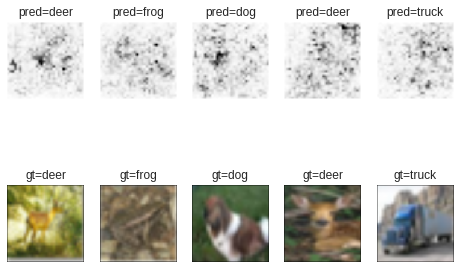

In [0]:
# Get saliency maps
smap, inp_img, predicted_class, ground_truth = sess.run(
      [saliency_op, batch_test_images, 
       pred_class_op, tf.squeeze(batch_test_labels)])

# Display 
gallery(smap, inp_img, predicted_class, ground_truth)


# Exercise - "Deep dream"

Find the images that maximize the probability of a given class using a gradient descent method.
Previous cell computed
$$
\frac{\partial y_{dog}}{\partial x}
$$
which you can use with gradient descent like approach:

$$
x_0 := \text{some initial dog}
$$
$$
x_{t+1} = \min(1, \max(-1, x_t + \alpha \frac{\partial y_{dog}}{\partial x})) 
$$

Similar analysis can be done on the level of specific neurons.

For the network we have, 
$$
\alpha = 0.1
$$
will work decently well, and a few thousands steps is enough.

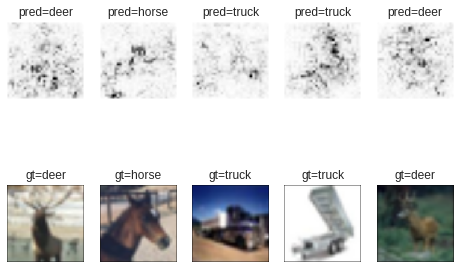

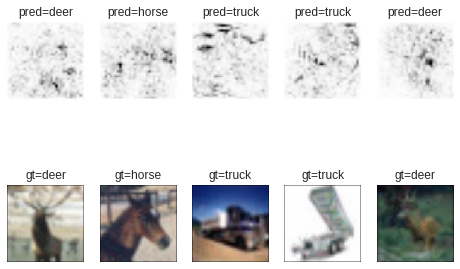

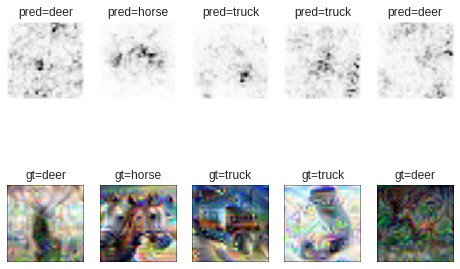

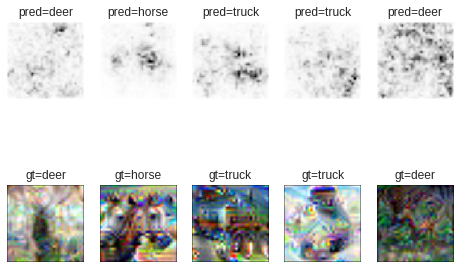

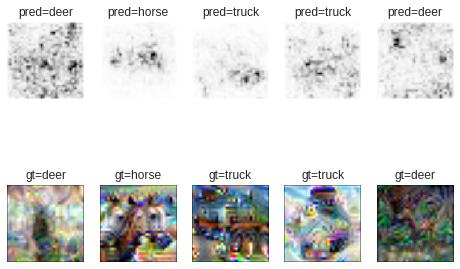

In [0]:
# Get saliency maps
smap, inp_img, predicted_class, ground_truth = sess.run(
      [saliency_op, batch_test_images, 
       pred_class_op, tf.squeeze(batch_test_labels)])

alpha = 0.1

# display 
gallery(smap, inp_img, predicted_class, ground_truth)

for k in range(10000):
     
    #############
    #           #
    # YOUR CODE #
    #           #
    #############
  
  if k % 1000 == 0:
    gallery(smap, inp_img, predicted_class, ground_truth)
  